# Application de l'article Improving Spacecraft Health Monitoring with Automatic Anomaly Detection Techniques

## Téléchargement des librairies

In [26]:
# Lecture des données
import pickle

# Librairies de base
import numpy as np
import pandas as pd
import scipy.stats as sps
import itertools

# Scikit learn
from sklearn import preprocessing
from sklearn import decomposition as sd
# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sb
sb.set()
sb.set_style("darkgrid", {"axes.facecolor": ".9"})

## Fonctions d'affichage

In [20]:
def plot_var_ACP(X_acp, acp) :
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,2,1)
    N = min(10, X_acp.shape[1])  # Nombre de composantes à afficher
    ax.bar(range(N), acp.explained_variance_ratio_[:N]*100, align='center', color='grey', ecolor='black')
    ax.set_xticks(range(N))
    ax.set_ylabel("Variance")
    ax.set_title("Pourcentage de variance expliquée \n des premières composantes", fontsize=20)

    ax = fig.add_subplot(1,2,2)
    box = ax.boxplot(X_acp[:, 0:N])
    ax.set_title("Distribution des premières composantes", fontsize=20)
    plt.show()
    
def plot_proj_ACP(X_acp, df, axe_1=0, axe_2=1, etiq=True, create_plot=True) :
    if create_plot:
        fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot(1,1,1)
    dict_color = {"appr" : "blue", "test" : "red"}

    for x, y, s, orig in zip(X_acp[:,axe_1], X_acp[:,axe_2], df.index.values, df["origine"]) :
        ax.plot(x, y, marker=".", color=dict_color[orig])
        if etiq :
            ax.text(x, y, str(s))
       
    ax.set_title("Projection des invididus sur les \n  deux premières composantes", fontsize=20)

    legend_elements = [Line2D([0], [0], marker='.', color='blue', label='Série du jeu d\'apprentissage', markersize=10, linewidth=0),
                       Line2D([0], [0], marker='.', color='red', label='Série du jeu de test', markersize=10, linewidth=0)]

    ax.legend(handles=legend_elements)
    
    if create_plot:
        plt.show()
    

## Chargement des données

On lit directement les données nettoyées et on récupère les jeux d'apprentissage et de test.

In [3]:
with open('liste_propre', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    liste_comp, ind = mon_depickler.load() #liste_comp : données  #ind : liste des indices des signaux
n = len(liste_comp) #nb de signaux
liste_appr = list(np.asarray(liste_comp)[np.asarray(ind) <= 299])
liste_test = list(np.asarray(liste_comp)[np.asarray(ind) > 299])
n_appr = len(liste_appr)

n_appr

297

## A) Pre-processing

### I) Data segmentation

On découpe chaque signal en fenêtre temporelles de longueur fixée. 

Nos signaux étant de longueurs différentes, on doit gérer le cas des fins de signaux qui ne constituent pas une fenêtre complète, par exemple les 150 derniers points d'un signal de longueur 350 pour une fenêtre de longueur 200. L'article ne décrit pas comment gérer ce cas.

On peut penser à plusieurs approches :
* Ignorer ces fins de signaux en espérant ne pas perdre trop d'information
* Utiliser des points de la fenêtre précédente pour arriver à la bonne longueur, quitte à dupliquer de l'information
* Mixer ces deux approches, par exemple (pour une fenêtre de longueur N) en utilisant la première si le nombre de points perdus est inférieur à N/2 et la deuxième sinon.

On commencera par implémenter la première pour des raisons de simplicité.

On range ces fenêtres temporelles dans un DataFrame contenant :
* id : indice de la fenêtre
* serie : numéro de la série temporelle dont provient la fenêtre
* origine : "appr" ou "test" suivant le jeu de données dont provient la série
* ind_debut : indice de la première valeur de la fenêtre dans la série d'origine
* valeurs : liste des N mesures de la fenêtre

In [4]:
def df_fenetres(liste_comp, N):
    serie = []
    origine = []
    ind_debut = []
    valeurs = []
    for ind, val in enumerate(liste_comp):
        # Liste des fenêtres de l'enregistrement
        fenetres = [val[i * N:(i + 1) * N] for i in range((len(val) + N - 1) // N ) if len(val[i * N:(i + 1) * N]) == N]
        nb_fen = len(fenetres)
        valeurs += fenetres
        ind_debut += list(range(0, nb_fen * N, N))
        serie += [ind] * nb_fen
        if ind < n_appr:
            origine += ["appr"] * nb_fen
        else:
            origine += ["test"] * nb_fen
        
    
    df = pd.DataFrame(data={"id" : list(range(len(serie))), "serie" : serie, "origine" : origine, "ind_debut" : ind_debut, "valeurs" : valeurs})
        
    return df.set_index(["id"])
        

In [5]:
data_fenetres = df_fenetres(liste_comp, 200)

In [6]:
data_fenetres.head(50)

,serie,origine,ind_debut,valeurs
id,,,,
0,0,appr,0,"[1424.0, 1432.0, 1432.0, 1416.0, 1408.0, 1408...."
1,0,appr,200,"[2248.0, 2248.0, 2248.0, 2248.0, 2240.0, 2240...."
2,0,appr,400,"[1680.0, 1680.0, 1672.0, 1664.0, 1672.0, 1672...."
3,1,appr,0,"[1400.0, 1384.0, 1384.0, 1392.0, 1400.0, 1400...."
4,1,appr,200,"[2160.0, 1792.0, 1736.0, 1704.0, 1720.0, 1808...."
5,2,appr,0,"[1416.0, 1424.0, 1424.0, 1424.0, 1424.0, 1416...."
6,2,appr,200,"[1688.0, 1688.0, 1688.0, 1672.0, 1672.0, 1672...."
7,2,appr,400,"[1672.0, 1680.0, 1688.0, 1680.0, 1680.0, 1680...."
8,2,appr,600,"[1672.0, 1672.0, 1680.0, 1680.0, 1672.0, 1664...."


In [7]:
data_fenetres.tail(50)

,serie,origine,ind_debut,valeurs
id,,,,
1215,408,test,200,"[1824.0, 1824.0, 1824.0, 1832.0, 1824.0, 1824...."
1216,409,test,0,"[1424.0, 1416.0, 1400.0, 1400.0, 1400.0, 1408...."
1217,409,test,200,"[1744.0, 1744.0, 1744.0, 1744.0, 1744.0, 1736...."
1218,410,test,0,"[1400.0, 1400.0, 1400.0, 1400.0, 1384.0, 1384...."
1219,410,test,200,"[1608.0, 1616.0, 1624.0, 1640.0, 1648.0, 1648...."
1220,410,test,400,"[1674.0, 1682.0, 1682.0, 1698.0, 1698.0, 1698...."
1221,411,test,0,"[1400.0, 1400.0, 1392.0, 1392.0, 1392.0, 1400...."
1222,411,test,200,"[1784.0, 1776.0, 1776.0, 1784.0, 1792.0, 1792...."
1223,412,test,0,"[1408.0, 1416.0, 1416.0, 1416.0, 1400.0, 1400...."


Exemple de plot des fenêtres en couleur :

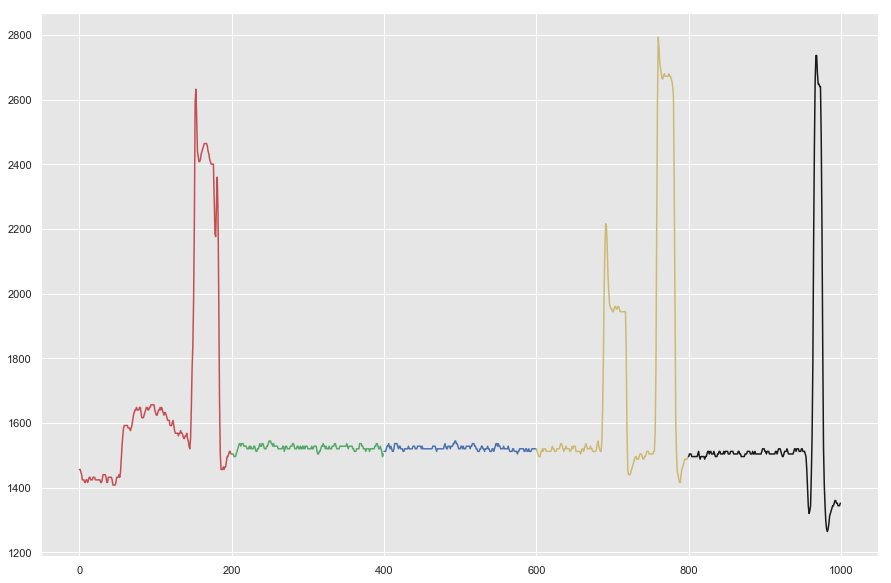

In [8]:
fig, ax = plt.subplots(figsize=(15, 10))

for i, x in enumerate(data_fenetres[data_fenetres["serie"] == 417]["valeurs"].values):
    ax.plot(range(200 * i, 200 * (i + 1)),  x, "rgbyk"[i%5])
plt.show()

### II) Features computation

Pour chaque fenêtre, on calcule les features suivantes :

- min
- max
- moyenne 
- écart type 
- Skewness 
- Kurtosis 
- Energy 
- Average Crossing 

A ajouter ?

- Distribution spectrale d'énergie 
- Pourcentage d'extrema locaux 

In [9]:
data_fenetres["min"] = list(map(min, data_fenetres.valeurs))
data_fenetres["max"] = list(map(max, data_fenetres.valeurs))
data_fenetres["mean"] = list(map(np.mean, data_fenetres.valeurs))
data_fenetres["std"] = list(map(np.std, data_fenetres.valeurs))
data_fenetres["skew"] = list(map(sps.skew, data_fenetres.valeurs))
data_fenetres["kurt"] = list(map(sps.kurtosis, data_fenetres.valeurs))
data_fenetres["energy"] = list(map(lambda x : sum(np.asarray(x)**2)/len(x), data_fenetres.valeurs))
data_fenetres["average_cross"] = list(map(lambda x : sum(1*(x > np.mean(x)))/len(x), data_fenetres.valeurs))

In [10]:
data_fenetres.head(10)

,serie,origine,ind_debut,valeurs,min,max,mean,std,skew,kurt,energy,average_cross
id,,,,,,,,,,,,
0,0,appr,0,"[1424.0, 1432.0, 1432.0, 1416.0, 1408.0, 1408....",1392.0,3128.0,1744.84,340.240289,1.922669,3.923076,3160230.08,0.195
1,0,appr,200,"[2248.0, 2248.0, 2248.0, 2248.0, 2240.0, 2240....",1600.0,2248.0,1762.48,190.731459,1.448893,0.378052,3142714.24,0.230
2,0,appr,400,"[1680.0, 1680.0, 1672.0, 1664.0, 1672.0, 1672....",1560.0,3552.0,1827.76,442.417294,2.877641,7.220898,3536439.68,0.170
3,1,appr,0,"[1400.0, 1384.0, 1384.0, 1392.0, 1400.0, 1400....",1368.0,3128.0,1624.80,250.145558,2.628173,12.262282,2702547.84,0.630
4,1,appr,200,"[2160.0, 1792.0, 1736.0, 1704.0, 1720.0, 1808....",1600.0,3320.0,1841.68,277.826524,2.530378,8.500516,3468972.80,0.325
5,2,appr,0,"[1416.0, 1424.0, 1424.0, 1424.0, 1424.0, 1416....",1392.0,2072.0,1636.60,144.236334,-0.424329,-0.041670,2699263.68,0.750
6,2,appr,200,"[1688.0, 1688.0, 1688.0, 1672.0, 1672.0, 1672....",1664.0,1704.0,1677.80,8.576713,0.344116,-0.438285,2815086.40,0.530
7,2,appr,400,"[1672.0, 1680.0, 1688.0, 1680.0, 1680.0, 1680....",1648.0,1696.0,1670.16,8.302674,0.282118,0.150872,2789503.36,0.580
8,2,appr,600,"[1672.0, 1672.0, 1680.0, 1680.0, 1672.0, 1664....",1280.0,1688.0,1616.88,116.404234,-1.852098,1.595310,2627850.88,0.830


### III) Data normalization

Les features sont normalisées pour qu'elles aient toutes la même influence sur le résultat final.


In [11]:
scaler = preprocessing.StandardScaler()
names_features = ["min", "max", "mean", "std", "skew", "kurt", "energy", "average_cross"]
for col in names_features:
    data_fenetres[col] = scaler.fit_transform(data_fenetres[col].values.reshape(-1, 1))

In [12]:
data_fenetres.head()

,serie,origine,ind_debut,valeurs,min,max,mean,std,skew,kurt,energy,average_cross
id,,,,,,,,,,,,
0,0,appr,0,"[1424.0, 1432.0, 1432.0, 1416.0, 1408.0, 1408....",-0.663928,1.015051,0.494511,0.936761,0.339995,-0.140400,0.476146,-1.063837
1,0,appr,200,"[2248.0, 2248.0, 2248.0, 2248.0, 2240.0, 2240....",0.655344,-0.129622,0.629330,0.048287,0.103609,-0.459738,0.443894,-0.903210
2,0,appr,400,"[1680.0, 1680.0, 1672.0, 1664.0, 1672.0, 1672....",0.401638,1.566575,1.128250,1.543960,0.816469,0.156671,1.168872,-1.178570
3,1,appr,0,"[1400.0, 1384.0, 1384.0, 1392.0, 1400.0, 1400....",-0.816152,1.015051,-0.422929,0.401363,0.691999,0.610803,-0.366598,0.932524
4,1,appr,200,"[2160.0, 1792.0, 1736.0, 1704.0, 1720.0, 1808....",0.655344,1.264798,1.234638,0.565860,0.643205,0.271940,1.044643,-0.467223


## B) Dimensionality reduction

On réduit la dimension du problème par ACP. L'article suggère de garder autant de composantes principales que nécessaire pour conserver 95% de la variance, on gardera ici seulement les plus significatives (cf M. Besse)

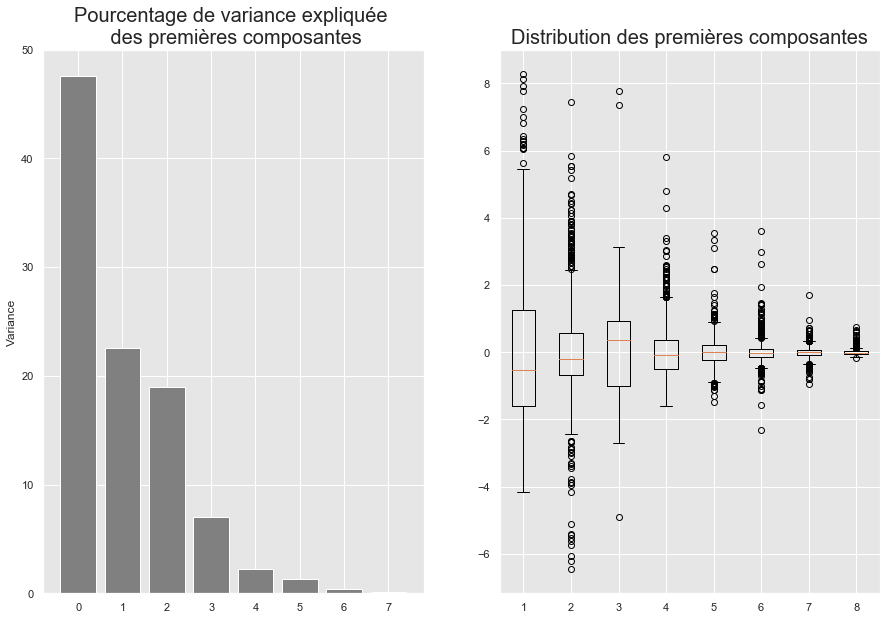

In [13]:
acp = sd.PCA()
X_acp = acp.fit_transform(data_fenetres[names_features])
plot_var_ACP(X_acp, acp)

Les 4 premières composantes semblent significatives.

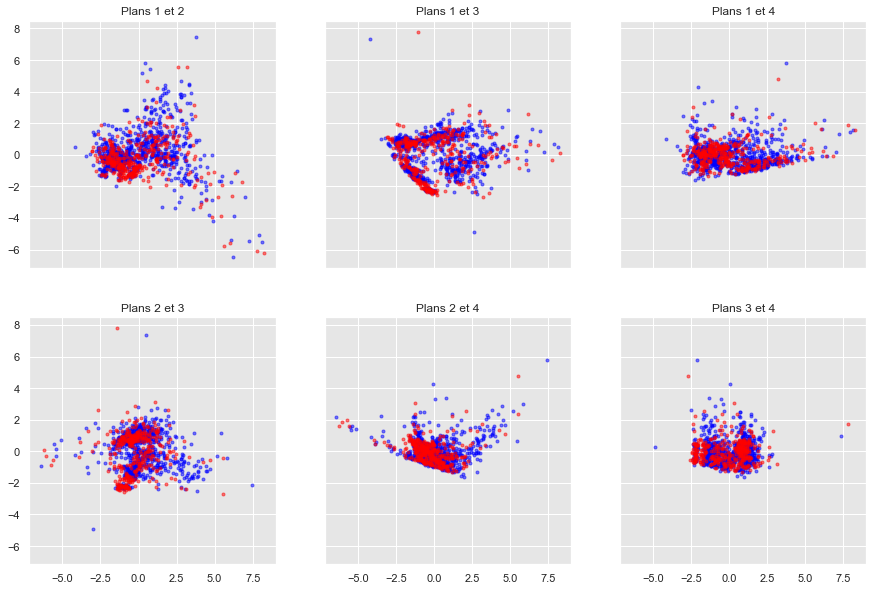

In [58]:
nb_compo = 4

fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15, 10))
dict_color = {"appr" : "blue", "test" : "red"}

for ax, plans in zip(axs.flatten(), itertools.combinations(range(nb_compo), 2)):
    for x, y, s, orig in zip(X_acp[:, plans[0]], X_acp[:, plans[1]], data_fenetres.index.values, data_fenetres["origine"]) :
        ax.plot(x, y, marker=".", color=dict_color[orig], alpha=0.5)
    
    ax.set_title("Plans " + str(plans[0] + 1) + " et " + str(plans[1] + 1))
    
plt.show()

## C) Application de la méthode OC-SVM

On applique OC-SVM sur les coordonnées de l'ACP --> les ajouter au data frame, les stocker ailleurs ?

Mais on verra demain, là c'est l'heure de dormir.